In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../..')

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from hydramuscle.model.smc import SMC
from hydramuscle.model.layer import Layer

In [4]:
numx = 30
numy = 60

In [5]:
T = 2
dt = 0.0001
save_interval=10
smc = SMC(T=T, dt=dt, k_ipr=0.2, s0=100, k_deg=0.05)

In [6]:
g_ca_list = np.arange(0.0001, 0.0011, 0.0001)
g_k_list = np.arange(0.0005, 0.0055, 0.0005)

In [7]:
ca_2d_list = []

for i, g_ca in enumerate(g_ca_list):
    
    ca_list = []
    print(str(i + 1) + '/' + str(len(g_ca_list)))
    
    for j, g_k in enumerate(g_k_list):
        
        smc._g_ca = g_ca
        smc._g_k = g_k

        layer = Layer(smc, 
                      numx=numx, 
                      numy=numy, 
                      gip3x=0.1, 
                      gip3y=2.0, 
                      gcx=1000, 
                      gcy=1000,
                      save_interval=save_interval)

        layer.set_stim_pattern(pathway='fast',
                               xmin=14, xmax=16, ymin=29, ymax=31,
                               stim_times=[0])

        sol = layer.run(save_all=True)

        # Extract calcium data
        calcium = sol[:, :numx * numy].reshape(-1, numx, numy)
        ca_list.append(calcium)
        
    ca_2d_list.append(ca_list)

  1%|▏         | 273/20000 [00:00<00:07, 2727.41it/s]

1/10


  1%|▏         | 289/20000 [00:00<00:06, 2880.44it/s]

2/10


  1%|▏         | 283/20000 [00:00<00:06, 2822.88it/s]

3/10


  1%|▏         | 285/20000 [00:00<00:06, 2846.46it/s]

4/10


  1%|▏         | 290/20000 [00:00<00:06, 2899.31it/s]

5/10


  1%|▏         | 288/20000 [00:00<00:06, 2878.07it/s]

6/10


  1%|▏         | 290/20000 [00:00<00:06, 2898.86it/s]

7/10


  1%|▏         | 287/20000 [00:00<00:06, 2864.01it/s]

8/10


  1%|▏         | 282/20000 [00:00<00:06, 2817.44it/s]

9/10


  1%|▏         | 282/20000 [00:00<00:06, 2817.52it/s]

10/10


100%|██████████| 20000/20000 [00:07<00:00, 2818.12it/s]


In [15]:
# Calculate the velocity for each calcium data

speed_2d_list = np.zeros((len(ca_2d_list), len(ca_2d_list[0])))
threshold = 0.055

for i, ca_list in enumerate(ca_2d_list):
    for j, calcium in enumerate(ca_list):
        ca_lon_half = calcium[:, numx//2, numy//2:]
        # Calculate velocity
        wavefronts = []
        for t in np.arange(0, 2, 0.001):
            concentrs = ca_lon_half[int(t / 0.001)]
            for k in range(numy // 2 - 1, -1, -1):
                if concentrs[k] > threshold:
                    break
            wavefronts.append(k) 
        speed = max(wavefronts) / ( np.argmax(wavefronts) * dt * save_interval * 1000 )
        speed_2d_list[i, j] = speed if not np.isnan(speed) else 0

/home/hengji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


In [16]:
speed_2d_list

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.11111111, 0.09090909, 0.06666667, 0.1       , 0.1       ,
        0.1       , 0.1       , 0.09090909, 0.09090909, 0.09090909],
       [0.11627907, 0.12121212, 0.06779661, 0.13043478, 0.10714286,
        0.075     , 0.15384615, 0.14285714, 0.13333333, 0.125     ],
       [0.74358974, 0.4084507 , 0.07638889, 0.1147541 , 0.08823529,
        0.11111111, 0.14814815, 0.12121212, 0.16666667, 0.15789474],
       [1.61111111, 1.38095238, 1.11538462, 0.725     , 0.49152542,
        0.13541667, 0.12676056, 0.14893617, 0.15      , 0.17241379],
       [2.23076923, 2.07142857, 1.93333333, 1.8125    , 1.45      ,
        1.03571429, 0.64444444, 0.53703704, 0.49152542, 0.18181818],
       [2.63636364, 2.63636364, 2.63636364, 2.41666667, 2.23076923,
        2.07142857, 1.93333333, 1.61111111, 1.16      , 0.65909091],
       [3.22222222, 3.22222222, 2.9      

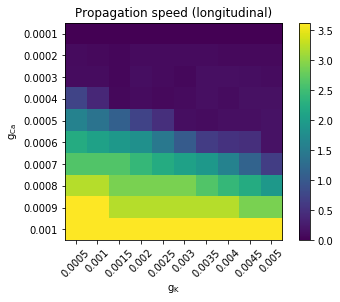

In [18]:
# Plot imshow

plt.figure()
plt.imshow(speed_2d_list)
plt.xticks(range(10), np.round(g_k_list, 4), rotation=45)
plt.yticks(range(10), np.round(g_ca_list, 4))
plt.xlabel('g$_\mathrm{K}$')
plt.ylabel('g$_\mathrm{Ca}$')
cbar = plt.colorbar()
# cbar.set_label('speed (cell/ms)')
plt.title('Propagation speed (longitudinal)')
plt.savefig('../../results/figures/gca-gk.pdf', bbox_inches='tight')
plt.show()

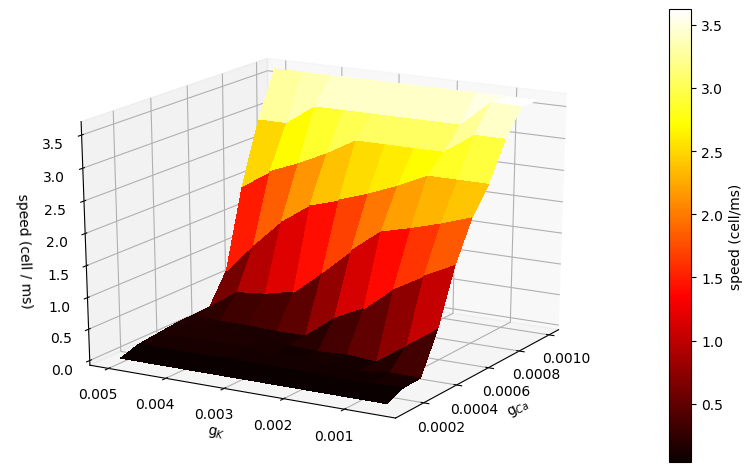

In [19]:
# Plot surface

fig = plt.figure(figsize=(10,6), dpi=100)
ax = plt.axes(projection='3d')
X = np.outer(np.array(g_ca_list), np.ones(len(g_k_list)))
Y = np.outer(np.ones(len(g_ca_list)), g_k_list)
surf = ax.plot_surface(X, Y, speed_2d_list, cmap='hot', antialiased=False)
ax.set_xlabel('g$_{Ca}$')
ax.set_ylabel('g$_K$')
ax.set_zlabel('speed (cell / ms)')
ax.view_init(20, 210)
cbar = fig.colorbar(surf)
cbar.set_label('speed (cell/ms)')
# plt.savefig('../../results/figures/gca-gk-surface.pdf', bbox_inches='tight')
plt.show()

In [11]:
plt.figure()
plt.plot(ca_2d_list[9, 0, :250, numx//2, numy//2])
plt.plot(ca_2d_list[9, 9, :250, numx//2, numy//2])
plt.show()

TypeError: list indices must be integers or slices, not tuple

<Figure size 432x288 with 0 Axes>

In [17]:
plt.figure()
plt.plot(ca_2d_list[9, 0, :250, numx//2, numy-1])
plt.plot(ca_2d_list[9, 9, :250, numx//2, numy-1])
plt.show()

TypeError: list indices must be integers or slices, not tuple

<Figure size 432x288 with 0 Axes>

In [18]:
smc._g_ca = 0.001
smc._g_k = 0.0005
smc.init_fast_cell()
smc._g_bk

0.00011061076182094129

In [19]:
smc._g_ca = 0.001
smc._g_k = 0.005
smc.init_fast_cell()
smc._g_bk

7.263445949819388e-05